# Assignment 4

## Angelo Rosace

#### 1st Assignment statement

Airbnb offers public data about its activities. We will focus on the file listing the available apartments in Barcelona in 2019.

We want to make a Naive Bayes Classifier that allow us to tell the neighbour where an apartment could be based on its latitude and longitude coordinates, to assign them to some apartments were the owner forget to upload it.
To test if its working just train it with 1000 apartments randomly chosen within the whole file, and test it for another different 1000. Which is the accuracy of your predictions.

In [1]:
import random as ra
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm

In order to takle the problem proposed by the assignment we would first have to load our data into a list and inspect them. Inspecting them will allow us to understand how the data i structured and will shed a light on how to handle them.

In [2]:
appartments = pd.read_csv("listings.csv", header = [0], sep = ",")
appartments

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,18666,Flat with Sunny Terrace,71615,Mireia And Maria,Sant Martí,el Camp de l'Arpa del Clot,41.40889,2.18555,Entire home/apt,130,3,1,2015-10-10,0.02,30,304
1,18674,Huge flat for 8 people close to Sagrada Familia,71615,Mireia And Maria,Eixample,la Sagrada Família,41.40420,2.17306,Entire home/apt,60,1,20,2019-10-19,0.25,30,312
2,23197,FORUM DELUXE 5 MINS WALK CCIB CENTER & SEA!,90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.41203,2.22114,Entire home/apt,210,3,51,2019-09-29,0.48,2,359
3,25786,NICE ROOM AVAILABLE IN THE HEART OF GRACIA,108310,Pedro,Gràcia,la Vila de Gràcia,41.40145,2.15645,Private room,32,1,268,2019-11-06,2.38,1,46
4,31958,"Gaudi Attic 1, Friendly Rentals",136853,Fidelio,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40950,2.15938,Entire home/apt,60,1,182,2019-10-16,1.71,39,324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20423,39968822,"Bright, sunshine white sophisticated",285303484,Ann,Horta-Guinardó,el Baix Guinardó,41.41177,2.16373,Entire home/apt,50,32,0,NaN,NaN,1,349
20424,39969034,"Fabulous, Modern Barcelona 2 Bedroom Apartment...",268096872,Allianz,Ciutat Vella,el Barri Gòtic,41.38576,2.17438,Entire home/apt,508,3,0,NaN,NaN,11,362
20425,39969285,Spectacular Luxurious 6 Bedroom Penthouse w/ P...,268096872,Allianz,Eixample,la Sagrada Família,41.40758,2.17242,Entire home/apt,1031,3,0,NaN,NaN,11,362
20426,39972885,Couples` Home with Parking,252088393,Joseph R.,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",41.39138,2.18240,Entire home/apt,89,3,0,NaN,NaN,1,22


The assignment asks us to just take in consideration altitude and longitude and neighborhood, therefore I will create a subset of the data that just holds informatin for this three variables.

In [3]:
appartment_useful_prop = appartments[["neighbourhood_group","latitude","longitude"]].copy()
appartment_useful_prop

,neighbourhood_group,latitude,longitude
0,Sant Martí,41.40889,2.18555
1,Eixample,41.40420,2.17306
2,Sant Martí,41.41203,2.22114
3,Gràcia,41.40145,2.15645
4,Gràcia,41.40950,2.15938
...,...,...,...
20423,Horta-Guinardó,41.41177,2.16373
20424,Ciutat Vella,41.38576,2.17438
20425,Eixample,41.40758,2.17242
20426,Ciutat Vella,41.39138,2.18240


Once we created our data set of interest we can go over to implement the arlogrithm. First of all I will implement a class describing the object *Appartment*

In [4]:
class Appartment( object ):
    
    def __init__(self, latitude, longitude, neighbourhood):
        self.latitude=latitude
        self.longitude=longitude
        self.neighbourhood=neighbourhood
    
    def getFeaturesDict(self): return {"latitude":self.latitude, "longitude": self.longitude, "neighbourhood": self.neighbourhood}
    
    def getNeighbourhood(self): return self.neighbourhood
    
    def getLatitude(self): return self.latitude
    
    def getLongitude(self): return self.longitude

Now that I create an object implementation of the class Appartment I can convert my data into objects and store them in a list.

In [5]:
to_objs = [list(appartment_useful_prop.loc[i]) for i in range(len(appartment_useful_prop))]
objs = [Appartment(item[1],item[2],item[0]) for item in to_objs]

To comply with the statement of the assignment I will use a training set of 1000 appartments and test the model against other 1000 appartments. I will therefore generate both training and testing set.

In [6]:
train_set = ra.sample(objs,k=1000)
test_set = ra.sample(objs,k=1000)
test_set_without_neighbourhood = [[i.getLatitude(), i.getLongitude()] for i in test_set]

The way the elements to put in the different sets where chosen was supposely random. For both sets a random sample of 1000 elements has been selected.  

Now that our two sets are ready we can finally go over to implementing the naive bayes algorithm.

In [7]:
class NaiveBayesOfAppartments( object ):
 
    def _distributionProbFunction(self,neighbourhood, Property):
        # Return the result of evaluating a Normal distribution of:
        #   mean equal to the mean of the property for this type of appartment
        #   std  equal to the std  of the property for this type of appartment
        return lambda x: norm.pdf( x, self.cmean[neighbourhood][Property],self.cstdv[neighbourhood][Property] )
        
    def __init__(self, appartments):
        self.appartments = appartments
 
        self.neighbourhoods = {}
        for appartment in self.appartments:
            if appartment.getNeighbourhood() in self.neighbourhoods.keys():
                self.neighbourhoods[appartment.getNeighbourhood()] += 1
            else: self.neighbourhoods[appartment.getNeighbourhood()] = 1
 
        self.probl = {}
        self.N = len(self.appartments[0].getFeaturesDict())
        self.properties = list(self.appartments[0].getFeaturesDict().keys())
        self.cmean = {}
        self.cstdv = {}
        self.prob = {}
        
        for neighbourhood in self.neighbourhoods.keys():
            # The amount of appartments of each type that I have in my "training" dataset
            self.probl[neighbourhood] = self.neighbourhoods[neighbourhood]/len(self.appartments)
            
            # I will store the mean, std, and normal probabiblity function,
            # of each property for each type of appartments
            self.cmean[neighbourhood] = {} #[0 for i in range(self.N)]
            self.cstdv[neighbourhood] = {} #[0 for i in range(self.N)]
            self.prob[neighbourhood] = {} #[0 for i in range(self.N)]
            
            # Then, for each property
            for i, prop in enumerate(self.properties):
                # Make a numpy array taking the list of the read properties
                try:
                    xi = np.array([float(e.getFeaturesDict()[prop]) for e in self.appartments if e.getNeighbourhood() == neighbourhood])
                except:
                    #This pass statement has been inserted becaused python would not allow turning the type of the variable to float.
                    #Although the e.getFeaturesDict()[prop] value should just be an integer variable, python recognize it as a tuple (int, string). THe string part of the tuple
                    #raises the exception. We know that the exception does not make sense because by printing the array xi we actually see that it just contains integer values.
                    #that is why we just pass the exception.
                    pass
                # Fullfill the mean with the mean, the std with the std and the prob with the probability function
                self.cmean[neighbourhood][prop] = xi.mean()
                self.cstdv[neighbourhood][prop] = xi.std()
                self.prob[neighbourhood][prop] = self._distributionProbFunction(neighbourhood,prop)

    def predict(self, X):
        p = {}
        
        # In the moment of predicting I have the probabilities of each feature of belonging to each class.
        for neighbourhood in self.neighbourhoods.keys():
            vectorToMultiply = [self._distributionProbFunction(neighbourhood,prop)(X[i]) for i, prop in enumerate(self.properties[:-1]) if self._distributionProbFunction(neighbourhood,prop)(X[i]) != 0.0 ]
            
            cp = np.prod( vectorToMultiply )
            
            p[neighbourhood] = self.probl[neighbourhood]*cp
            
        results = [(p[neighbourhood],neighbourhood) for neighbourhood in self.neighbourhoods.keys()]
        results.sort()
        return [results[-1][1], results[-1][0]/sum([r[0] for r in results])]

    def plotDistributions(self):
        for i, prop in enumerate(self.properties):
            nprops=len(range(self.N))
            rows = int(nprops/2)+int(nprops%2)
            plt.subplot(rows,2,i+1)
            for neighbourhood in list(self.neighbourhoods.keys()):
                mean = self.cmean[neighbourhood][prop]
                var = self.cstdv[neighbourhood][prop]
                x= np.linspace(mean-4*var,mean+4*var,200)
                xmin,xmax=plt.xlim()
                plt.xlim(min(xmin,mean-3*var),max(xmax,mean+3*var))
                plt.title(self.properties[i])
                
                self.prob[neighbourhood][prop] = self._distributionProbFunction(neighbourhood,prop)

                plt.plot(x,self.prob[neighbourhood][prop](x), label = neighbourhood)
                leg = plt.legend(loc="upper left")
                leg.get_frame().set_alpha(0.7)
        plt.show()

Once completed the implementation of the algorithm we have to generate our model.

In [8]:
NBC_model = NaiveBayesOfAppartments(train_set)
print(NBC_model.probl)

{'Eixample': 0.303, 'Ciutat Vella': 0.256, 'Horta-Guinardó': 0.026, 'Sants-Montjuïc': 0.122, 'Sant Martí': 0.105, 'Sant Andreu': 0.021, 'Gràcia': 0.084, 'Les Corts': 0.026, 'Nou Barris': 0.009, 'Sarrià-Sant Gervasi': 0.048}


The dictionary outputed above describes us the model that explains our training set and furthermore tells us which is the probability of a flat to be in one or the other neighbourhood group.

Now we can use this model to test our testing set.

Testing our model will mean using our model to predict the neighbourhood of each appartment in the set. Then we will compare the result with our original set to see if the prediction was correct and to which extent.

In [9]:
prediction = []
for appartment in test_set_without_neighbourhood:
    prediction.append(NBC_model.predict(appartment))

Now that we have our prediction we will check it against the test_set (with the information about the neighbour group) in order to understand how precise our prediction was.

In [10]:
pred_right = 0
pred_wrong = 0

for i,pred in enumerate(prediction):
    if pred[0] == test_set[i].getNeighbourhood():
        pred_right += 1
    else:
        pred_wrong += 1

accuracy = (pred_right/(pred_right+pred_wrong))*100
print("By comparing my prediction to the original test_set we can see that my model obtains an accuracy of",accuracy,"%")

By comparing my prediction to the original test_set we can see that my model obtains an accuracy of 89.0 %


#### 2nd Assignment statement

We want to clusterize the apartments according to their prize and room type (1: shared room, 2: private room, 3: hotel room, 4: entire apartment). Plotting different amount of clusters according to this and other features (neighbourhood, availability, minimum nights).

Can we draw any conclusions?

In [11]:
import math

We already imported the data we need but now the assignment to tackle is about clusterization rather then classification.
For this reason we will implement a k-means algorithm.

K-means is an algorithm that allow us to clusterize our data according to the variables of the data set we are analysing. For this purpose the approach requires the definition of distances between the elements of our data set. This distances will be calculated by means of the eucledian theorem.

We therefore have to implement a function that allow us to compute this distances.

In [96]:
def vector_euclidian_distance(feat_one, feat_two):
    squared_distance = 0
    #Assuming correct input to the function where the lengths of two features are the same
    for i in range(len(feat_two)-1):
            squared_distance += (feat_one[i] - feat_two[i])**2
    ed = math.sqrt(squared_distance)
    return ed

Now that we defined the type of distance we will be using in the algorithm let's go over implementing a class for it.

In [77]:
class K_Means:

    def __init__(self, k =3, tolerance = 0.0001, max_iterations = 300):
        self.k = k
        self.tolerance = tolerance
        self.max_iterations = max_iterations
    

    def fit(self, data):
        #initialize the centroids, the first 'k' elements in the dataset will be our initial centroids
        self.centroids = [None for _ in range(self.k)]
        #self.centroids = [i[0:2] for i in data[0:self.k]]
        for i in range(self.k):
            #self.centroids[i] = data[i]
            self.centroids[i] = data[i]

        for i in range(self.max_iterations):
            self.classes = {c:[] for c in range(self.k)}
            for i in range(self.k):
                self.classes[i] = []

                #find the distance between the point and cluster; choose the nearest centroid
                for features in data:
                    distances = [vector_euclidian_distance(features, self.centroids[centroid]) for centroid in range(len(self.centroids))]
                    classification = distances.index(min(distances))
                    self.classes[classification].append(features)
            
            #previous = dict(self.centroids)
            
            #average the cluster datapoints to re-calculate the centroids
            for classification in self.classes:
                self.centroids[classification] = np.average(self.classes[classification], axis = 0)
            

Now that we implemented the k means class we have to prepare the data we want to feed to the algorithm. Once we did that we can cluster our data by means of the k-means algorithm.

In [78]:
clustering_set = appartments.sample(frac=0.1, replace=True)
X = clustering_set["longitude"]
Y = clustering_set["latitude"]

Once the algorithm has finished processing the data we can finally plot them. We will do it differentiating the elements in turn by price, room type, neighbourhood, availability and minimum nights.

**Clusterization by Prize**

Let's first of all define a scale for the prices. We know that the maximum and the minimum prices are respectively:

In [80]:
price = appartments["price"]
maxP = max(price)
print(maxP, "and", min(price))

15000 and 0


This will be the extremes of our color scale. Let us then define different price levels that will in turn correspond to a different color. We will define 5 levels that represent spans from very low to very high for which we will clusterize the appartments.

In [98]:
P = clustering_set["price"]
new_P = []

for i in P:
    if i <= 50:
        new_P.append(1)
    if i > 50 and i <= 300:
        new_P.append(2)
    if i > 300 and i <= 1000:
        new_P.append(3)
    if i > 1000 and i <= 2500:
        new_P.append(4)
    if i > 2500 and i < maxP:
        new_P.append(5)

Z = list(zip(X,Y,new_P))
km = K_Means(5)
km.fit(Z)
print("K-mean algorithm ran correctly")

K-mean algorithm ran correctly


Centroid: [ 2.17895686 41.38669258]
Centroid: [ 2.16171424 41.38127715]
Centroid: [ 2.19642783 41.41273327]
Centroid: [ 2.13740114 41.3806372 ]
Centroid: [ 2.16280476 41.40656177]


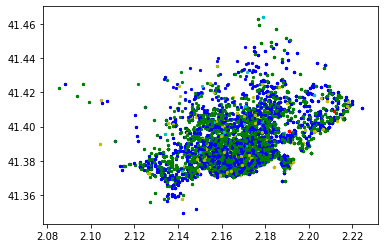

In [101]:
colors = {
    1:"b",
    2:"g",
    3:"y",
    4:"r",
    5:"c",
    6:"k",
    7:"m",
    8:[106/255, 90/255, 205/255],
    9:[151/255, 255/255, 0],
    10:[151/255, 122/255, 0]
} 

for centroid in km.centroids:
    print ("Centroid:", centroid[0:2])

for c,classification in enumerate(km.classes):
    for p,features in enumerate(km.classes[classification]):
        plt.scatter(features[0], features[1], color = colors[features[2]],s = 5)

**Clusterization by room type**

We know that we have four room types (1: shared room, 2: private room, 3: hotel room, 4: entire apartment) and in order to use them to clusterize our data we will first have to map those types to numeric values. After having mapped the room types we can go on to run the K-means algorithm and plot the results.

In [102]:
rooms = clustering_set["room_type"]
mapped_rooms = []

for room in rooms:
    if room == "Shared room":
        mapped_rooms.append(1)
    if room == "Private room":
        mapped_rooms.append(2)
    if room == "Hotel room":
        mapped_rooms.append(3)
    if room == "Entire home/apt":
        mapped_rooms.append(4)
        
Z = list(zip(X,Y,mapped_rooms))
km = K_Means(4)
km.fit(Z)
print("K-mean algorithm ran correctly") 

K-mean algorithm ran correctly


Centroid: [ 2.16300001 41.40571411]
Centroid: [ 2.17188172 41.38284053]
Centroid: [ 2.19427304 41.40951676]
Centroid: [ 2.14396154 41.38139271]


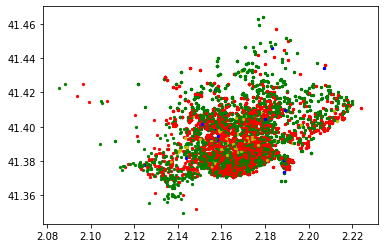

In [103]:
for centroid in km.centroids:
    print ("Centroid:", centroid[0:2])

for c,classification in enumerate(km.classes):
    for p,features in enumerate(km.classes[classification]):
        plt.scatter(features[0], features[1], color = colors[features[2]],s = 5)

By comparing the plot for the price and this last one we can already see that the central part of Barcelona is where we have the most biggest appartments. By comparing the two previous plots we actually see that size does not directly imply that the appartment is going to be expansive. This can be for the most cases be considered a general rule but we have evidence of some appartments that are expensive although being just a private room. That could be do to the neighbourhood in which that particular room. By further analysing the different varaibles of the data set we will probabliy uncover more underlyng patterns that could maybe explain this initial guess.

**Clusterization by neighbourhood group**

We know that our data set contains appartments located in eleven different neighbourhood groups. Those are:

In [104]:
neighbourhoods = set(appartments["neighbourhood_group"])
print(neighbourhoods)

{'Eixample', 'Sants-Montjuïc', 'Sarrià-Sant Gervasi', 'Gràcia', 'Sant Martí', 'Horta-Guinardó', 'Nou Barris', 'Les Corts', 'Ciutat Vella', 'Sant Andreu'}


We now want to clusterize our data in the different neighbourhoods.

In [105]:
neighs = clustering_set["neighbourhood_group"]
N = []

for neigh in neighs:
    if neigh == "Eixample":
        N.append(1)
    if neigh == "Sants-Montjuïc":
        N.append(2)
    if neigh == "Sarrià-Sant Gervasi":
        N.append(3)
    if neigh == "Gràcia":
        N.append(4)
    if neigh == "Sant Martí":
        N.append(5)
    if neigh == "Horta-Guinardó":
        N.append(6)
    if neigh == "Nou Barris":
        N.append(7)
    if neigh == "Les Corts":
        N.append(8)
    if neigh == "Ciutat Vella":
        N.append(9)
    if neigh == "Sant Andreu":
        N.append(10)

Z = list(zip(X,Y,N))
km = K_Means(4)
km.fit(Z)
print("K-mean algorithm ran correctly") 

K-mean algorithm ran correctly


Centroid: [ 2.16300001 41.40571411]
Centroid: [ 2.17188172 41.38284053]
Centroid: [ 2.19427304 41.40951676]
Centroid: [ 2.14396154 41.38139271]


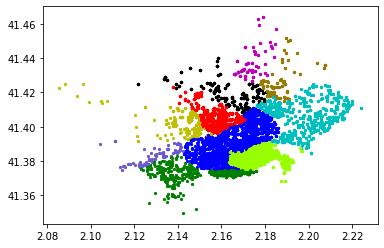

In [106]:
for centroid in km.centroids:
    print ("Centroid:", centroid[0:2])

for c,classification in enumerate(km.classes):
    for p,features in enumerate(km.classes[classification]):
        plt.scatter(features[0], features[1], color = colors[features[2]],s = 5)

By comparing the three plots we can se that the most expensive appartments are towards the outskirts of Barcelona which means around the neighbourhoods of Sant Martì, Gracia and Nou Barris.

**Clusterization by availability**

At the moment in which we downloaded the data some of the appartments where avalible and some not. We want to clusterize the data accordingly to this variable. The varaible tells us how many days a certain appartment is available for this year. In order to clusterize the data we will consider four different ranges of ammounts of avvailable days (up to 1 month, from 1 to 3 moths, from 3 to 6 months, more then 6 moths) 

In [108]:
availability = clustering_set["availability_365"]
A = []

for av in availability:
    if av <= 31:
        A.append(1)
    if av > 31 and av <= 66:
        A.append(2)
    if av > 66 and av <= 186:
        A.append(3)
    if av > 186:
        A.append(4)

Z = list(zip(X,Y,A))
km = K_Means(4)
km.fit(Z)
print("K-mean algorithm ran correctly")

K-mean algorithm ran correctly


Centroid: [ 2.16300001 41.40571411]
Centroid: [ 2.17188172 41.38284053]
Centroid: [ 2.19427304 41.40951676]
Centroid: [ 2.14396154 41.38139271]


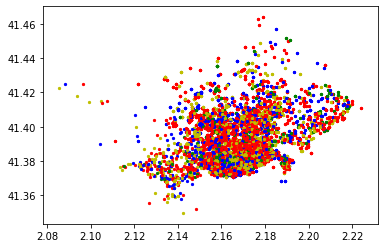

In [109]:
for centroid in km.centroids:
    print ("Centroid:", centroid[0:2])

for c,classification in enumerate(km.classes):
    for p,features in enumerate(km.classes[classification]):
        plt.scatter(features[0], features[1], color = colors[features[2]],s = 5)

By looking at this last graph we see a higher concentration of red dots. This means that generally people would try to rent houses for a shorter amount of time, therefore leaving a higher amount of avvailable days. That makes sense if we think that AirBnb is a platform for short-term hause renting.

**Clusterization by minimum nights**

At the moment in which we downloaded the data we also have some information about the duration of a minimum stay in all the appartments. We want now to cluster our data basing our selves on this variable.
By inspecting the data set we see that this particular variable is continuous. Therefore, in order to propperly clusterize the data I will firs inspecct the variable. In particular I want to know which are the minimum and maximum values for the variable. 

In [112]:
nights = clustering_set["minimum_nights"]
print("the variable has values that range from", min(nights), "to", max(nights))

the variable has values that range from 1 to 365


Taking this in consideration we will define a 4 ranks for the varaibles, exactly as we did for the availability varaible.

In [117]:
nig = []

for n in nights:
    if n <= 31:
        nig.append(1)
    if n > 31 and av <= 66:
        nig.append(2)
    if n > 66 and av <= 186:
        nig.append(3)
    if n > 186:
        nig.append(4)

Z = list(zip(X,Y,nig))
km = K_Means(4)
km.fit(Z)
print("K-mean algorithm ran correctly")

K-mean algorithm ran correctly


Centroid: [ 2.16468541 41.40650835]
Centroid: [ 2.17200535 41.38295836]
Centroid: [ 2.19691461 41.40958029]
Centroid: [ 2.14445391 41.38193834]


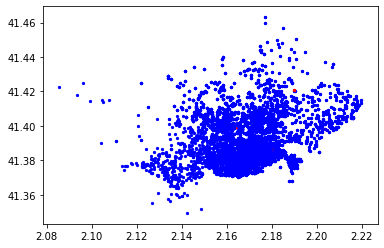

In [118]:
for centroid in km.centroids:
    print ("Centroid:", centroid[0:2])

for c,classification in enumerate(km.classes):
    for p,features in enumerate(km.classes[classification]):
        plt.scatter(features[0], features[1], color = colors[features[2]],s = 5)

Last but not least we consider this last graph. By looking at it is immediately clear that the most of the appartments or almost all of them are being rented for not more than a month which again makes sense considering the purpose of the service that AirBnb provides.

Finally, by collecting all this information we can conclude that not surprisingly a pricier house is harder to rent for a longer amount of time and that it will likely be placed in the outskirts of Barcelona.
Moreover we can spot a tendency to rent full appartments/houses.
In general, very few houses are unavailable for more then one month.